# Welcome to Santiment Onchain metrics Tutorial!

In [1]:
%%html
<style>
table {float:left}
</style>

**In this tutorial you'll learn:**
1. How to access the data stored in ClickHouse using ClickHousePyDriver
2. What data is available
3. What features could be computed from blockchain 
4. How to compute basic blockchain features from the example of Ethereum blockchain

## Accessing the data 

The data is stored in **ClickHouse**.

ClickHouse is a *column-oriented* database management system (DBMS) for online analytical processing of queries (OLAP).<br>
You can find ClickHose documentation [here](https://clickhouse.yandex/docs/en/).

In order to access the data you can use [clickhouse-driver](https://pypi.org/project/clickhouse-driver/):

In [2]:
# import client
from clickhouse_driver import Client

In [3]:
# to connect Clickhouse cluster use 'clickhouse' as a HostName.
HOST = 'clickhouse'

# data is stored using lz4 comression. You have to specify this creating the client.
COMPRESSION = 'lz4'

# create client itself.
client = Client(host = HOST, compression = COMPRESSION)

## Available data

Ethereum blockchain data is stored in 2 tables: 
1. eth_transfers
2. erc20_transfers

Every row in both tables is a transaction but single onchain transaction corresponds to multiple rows.

1. **eth_transfers** table consists of columns:

| column_name | data_type | description |
|---|---|---|
| dt | DateTime | Transaction's datetime |
| from | String | The address sending Ether |
| to | String | The address receiving Ether |
| value | Float64 | Sent amount of Ether, wei |
| valueExactBase36 | String | Raw sent amount of ETH, wei |
| blockNumber | UInt32 | Height of the block with given transaction |
| transactionHash | String | Transaction's hash |
| transactionPosition  | UInt32 | Transaction's position |
| type  | Enum8 | One of (call', 'fee', 'genesis', 'suicide', 'reward', 'create', 'dao_hack'). See description below.|
| primaryKey  | UInt64 | service stuff |

Transactions' types:
1. **call** is a usual transfer.
2. **fee** is a fee sent to miner by address-sender. 
3. **genesis** is a special tag used for initial distribution of Ether in block #0.
4. **suicide** is a transfer cause smart contract destruction.
5. **reward** is a miner's reward for block creation. 
6. **create** is a transfer creating smart contract.
7. **dao_hack** DAO_HACK_HARD_FORK transfers.




2. **erc20_transfers** table consists of columns:

| column_name | data_type | description |
|---|---|---|
| dt | DateTime | Transaction's datetime |
| from | String | The address sending tokens |
| to | String | The address receiving toekns |
| value | Float64 | Sent amount of tokens |
| contract | String | The address of sent token's contract |
| valueExactBase36 | String | Raw sent amount |
| blockNumber | UInt32 | Height of the block with given transaction |
| transactionHash | String | Transaction's hash |
| logIndex  | Enum8 | service stuff |
| primaryKey  | UInt64 | service stuff |


## Getting the data

ClickHouse supports a declarative query language based on SQL that is identical to the SQL standard in many cases. <br>
Supported queries include GROUP BY, ORDER BY, subqueries in FROM, IN, and JOIN clauses, and scalar subqueries. <br>
Dependent subqueries and window functions are not supported.

In [4]:
# to get the data write a sql statement:
# get any one row from block #7,000,000
sql = """SELECT from, to, value, dt, transactionHash, blockNumber, type FROM eth_transfers WHERE blockNumber = 7000000 LIMIT 1"""

# execute sql statement
response = client.execute(sql)

# show the result
response

[('0x0ff8d2412b13ff129f53ee8dd0eda5f2ae600494',
  '0xb2930b35844a230f00e51431acae96fe543a0347',
  1431792000000000.0,
  datetime.datetime(2019, 1, 2, 22, 9, 12),
  '0xa72d6ae2871b32d91a12dc4890c65b112d92b623a205d53e7b8762a4e62596a3',
  7000000,
  'fee')]

The client returns list with tuples. In most cases it's more convinient to work with the data using pandas DataFrames.

In [5]:
# import pandas
import pandas as pd

# specify DataFrame's column names
columns = ['from', 'to', 'value', 'dt', 'transactionHash', 'blockNumber', 'type']

# convert responce to pandas DataFrame
df = pd.DataFrame(response, columns = columns)

# show the DataFrame
df

,from,to,value,dt,transactionHash,blockNumber,type
0,0x0ff8d2412b13ff129f53ee8dd0eda5f2ae600494,0xb2930b35844a230f00e51431acae96fe543a0347,1.431792e+15,2019-01-02 22:09:12,0xa72d6ae2871b32d91a12dc4890c65b112d92b623a205...,7000000,fee


### Example 1: Get all addresses ever mined blocks (miners) with the number of mined blocks

In [6]:
sql = """
SELECT to, count(to)
FROM eth_transfers
WHERE type = 'reward' --use 'type' field to identify miners
                      --miner is an address ever mined block, i.e. it received a reward for created block.
GROUP BY to
ORDER BY count(to) DESC
"""

miners = client.execute(sql)

miners = pd.DataFrame(miners, columns = ['miner', 'mined_blocks'])

In [7]:
miners.head()

,miner,mined_blocks
0,0xea674fdde714fd979de3edf0f56aa9716b898ec8,1415731
1,0x2a65aca4d5fc5b5c859090a6c34d164135398226,986831
2,0x52bc44d5378309ee2abf1539bf71de1b7d7be3b5,929981
3,0x829bd824b016326a401d083b33d092293333a830,684096
4,0x5a0b54d5dc17e0aadc383d2db43b0a0d3e029c4c,520455


### Example 2: Get number of all BINANCE token transfers for the last 24h

In [8]:
sql = """
SELECT uniqExact(transactionHash)
FROM erc20_transfers
WHERE contract = '0xb8c77482e45f1f44de1745f52c74426c631bdd52'
    AND dt >= dateDiff('hour', dt, now()) <= 24
"""

# uniqExact() is built-in ClickHouse function. It comoutes the number of rows with unique values.

# use field contract search for necesary token. 
    # '0xb8c77482e45f1f44de1745f52c74426c631bdd52' is BINANCEcoin contract. 
    
# dateDiff('unit', t1, t2, [timezone]) returns the difference between two times expressed in chosen tiemunit.
    # for more visit https://clickhouse.yandex/docs/en/query_language/functions/date_time_functions/#datediff-unit-t1-t2-91-timezone-93

# now() returns the current time at one of the moments of request execution. 

number_of_transfers = client.execute(sql)

# show number of BNB token transfers for last 24 hours.
number_of_transfers[0][0]

517216

### Example 3: Get all addresses received both ETH and SANTIMENT token in 2019

To get list needed addresses you have to:
1. Get list of addresses which received SAN tokens in 2019 
2. Get list of addresses which received ETH in 2019
3. Get addresses which present in both lists.

Note that there are muiltiple ways to achieve that. <br>
Lets benchmark 3 different queries giving same results. 

1. The first way is to use **JOIN**.<br>
Visit JOIN section for more info: https://clickhouse.yandex/docs/en/query_language/select/#select-join

In [9]:
%%time 

sql = """
SELECT to
FROM
    (
    SELECT distinct to
    FROM eth_transfers
    WHERE dt >= toDateTime('2019-01-01 00:00:00')
    )
ANY INNER JOIN
    (
    SELECT distinct to 
    FROM erc20_transfers
    WHERE contract = '0x7c5a0ce9267ed19b22f8cae653f198e3e8daf098'
        AND dt >= toDateTime('2019-01-01 00:00:00') 
    )
USING to
"""

# note that it's much more efficient to filter 'dt' column twice in every subquery 
    # than joining full data and filtering by dateTime afterwards (after 'USING' statement) 

df = client.execute(sql)

CPU times: user 480 ms, sys: 48 ms, total: 528 ms
Wall time: 2.88 s


2. The second way is to use **GLOBAL IN** statement.<br>
Visit IN section for more info: https://clickhouse.yandex/docs/en/query_language/select/#select-in-operators

There are also 2 ways to use **IN** statement:

1. filter out all addresses received ETH and select among them those which received SAN tokens
2. filter out all addresses received SAN and select among them those which received ETH tokens

Despite it looks quite similar there's a significant difference in perfomance. Lets check that!

In [10]:
%%time

sql = """
SELECT distinct to
FROM eth_transfers
WHERE dt >= toDateTime('2019-01-01 00:00:00')
    AND to GLOBAL IN (SELECT distinct to 
                     FROM erc20_transfers
                     WHERE contract = '0x7c5a0ce9267ed19b22f8cae653f198e3e8daf098'
                         AND dt >= toDateTime('2019-01-01 00:00:00')
                     )
"""
df = client.execute(sql)

CPU times: user 28 ms, sys: 12 ms, total: 40 ms
Wall time: 563 ms


In [11]:
%%time

sql = """
SELECT distinct to
FROM erc20_transfers
WHERE dt >= toDateTime('2019-01-01 00:00:00')
    AND contract = '0x7c5a0ce9267ed19b22f8cae653f198e3e8daf098'
    AND to GLOBAL IN (SELECT distinct to 
                     FROM eth_transfers
                     WHERE dt >= toDateTime('2019-01-01 00:00:00')
                     )
"""
df = client.execute(sql)

CPU times: user 4 ms, sys: 8 ms, total: 12 ms
Wall time: 3.91 s


You see that the first way is ~10 times faster (on average). <br>
It happens so because there are much more ETH transfers than SAN transfers and ClickHosue executes first statement in WHERE clause.

Also first way is faster that JOIN query (in most cases IN statements are more efficient tham JOINs)

**Optimization is quite important thing to think about. These toy examples illustrate the difference between approaches.**

In [12]:
# check the result

# df
len(df)

181

## Computing basic blockchain metrics

### Example 1: TransactionVolume

**TransactionVolume** shows the aggregate amount of tokens across all transactions that happened on the network on a certain date.<br>
Note that the metrics shows onchain transferred amount of tokens (or ETH) and does not show exchanges' trading volume.

In [13]:
# Lets compute daily ETH transactionVolume since the beginning of the year.  

sql = """
SELECT sum(value)/pow(10,18), toStartOfDay(dt)
FROM eth_transfers 
WHERE dt >= toDateTime('2019-01-01 00:00:00') 
    AND dt < toDateTime(today())
    AND type != 'call'
GROUP BY toStartOfDay(dt)
ORDER BY toStartOfDay(dt)
"""

transactionVolume = client.execute(sql)
transactionVolume = pd.DataFrame(transactionVolume, columns = ['volume', 'dt']).set_index('dt')

transactionVolume.head()

,volume
dt,
2019-01-01,19098.818167
2019-01-02,19511.145986
2019-01-03,18287.594748
2019-01-04,18201.413691
2019-01-05,18517.622024


In [14]:
# take a look into the data
transactionVolume.plot()

### Example 2: Daily Active Addresses

**Daily Active Addresses** (DAA) shows the number of unique network addresses involved in transactions on a certain date. <br> DAA indicates the amount of network participants (activity level within a certain network).

In [15]:
sql = """
SELECT uniqExact(arrayJoin([from, to])), toStartOfDay(dt)
FROM erc20_transfers
WHERE contract = '0x7c5a0ce9267ed19b22f8cae653f198e3e8daf098'
GROUP BY toStartOfDay(dt)
ORDER BY toStartOfDay(dt)
"""

daa = client.execute(sql)
daa = pd.DataFrame(daa, columns = ['daa','dt']).set_index('dt')

daa.tail()

,daa
dt,
2019-02-24,16
2019-02-25,19
2019-02-26,15
2019-02-27,10
2019-02-28,16


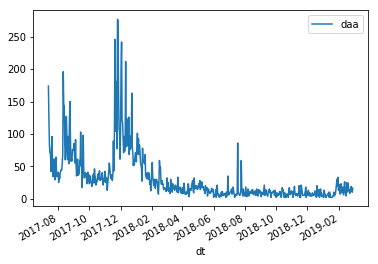

In [16]:
# take a glimpse at the data
# ignore first day outlier
daa[1:].plot()

### Example 3: Transaction fees per block

**Transaction fees** is the sum of all transaction fees in the block sent to miners. <br> 
In other words it's miners' reward excluding constant reward for block creation. 

In [17]:
sql = """
SELECT sum(value)/pow(10,18), blockNumber
FROM eth_transfers
WHERE type = 'fee'
    AND dt >= toDateTime('2019-01-01 00:00:00')
GROUP BY blockNumber
ORDER BY blockNumber
"""

fees = client.execute(sql)
fees = pd.DataFrame(fees, columns = ['totalFees','blockNumber']).set_index('blockNumber')
fees.tail()

,totalFees
blockNumber,
7279992,0.071901
7279993,0.134100
7279994,0.090289
7279995,0.068718
7279996,0.072696


__________________

**Congratulations on completing the tutorial.**

Find more tutorails [here](https://github.com/santiment/KDD-2019).

If you have any questions contact team in [Santiment Discord](https://discord.gg/MMJvbQz) or [Santiment Telegram](https://t.me/santiment_network).<br>
You can find FAQ and more metrics explained visiting [Santiment KnowledgeBase](https://help.santiment.net/).